# Crypto Deep Learning — Preprocessing (2020_2025-12-25, 1h)
This notebook fetches **Binance USD-M perpetual futures** OHLCV (via `ccxt`) and **funding rates** (via Binance Futures API),
aligns everything to a **1-hour grid**, and builds features for the proposal hypotheses:

- `ret_1h` (log return)
- `realized_vol` (rolling std of returns, 24h window)
- `rsi` (RSI-14)
- **Correct divergence signal** `rsi_div` (directional divergence):
  - **bearish divergence**: price trend up while RSI trend down → `rsi_div = -1`
  - **bullish divergence**: price trend down while RSI trend up → `rsi_div = +1`
  - otherwise `rsi_div = 0`
- `fundingRate` (ffill from 8h funding onto hourly grid)

Outputs:
- `data/processed/features_BTCUSDT.parquet`, etc.

> > Study period is strictly **2020-01-01 00:00:00 UTC** to **2025-12-25 23:00:00 UTC** (hard-trimmed).


In [1]:
# Colab / local compatible setup
!pip -q install ccxt pyarrow requests

import time
from datetime import datetime, timezone
from typing import Dict, List, Optional
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ccxt
import requests

plt.style.use("ggplot")

SEED = 42
np.random.seed(SEED)

# --- Configuration ---
PERP_SYMBOLS = ["BTCUSDT", "ETHUSDT", "SOLUSDT"]
# ccxt uses symbols like BTC/USDT:USDT for USD-M perps
PERP_SYMBOLS_CCXT = ["BTC/USDT:USDT", "ETH/USDT:USDT", "SOL/USDT:USDT"]

TIMEFRAME = "1h"

# Study period (UTC) — strict 2020_2025-12-25
START_DATE = "2020-01-01 00:00:00"
END_DATE   = "2025-12-25 23:00:00"
PERIOD_TAG = "2020_2025-12-25"

def to_millis(dt_str: str) -> int:
    dt = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc)
    return int(dt.timestamp() * 1000)

START_MS = to_millis(START_DATE)
END_MS   = to_millis(END_DATE)

print("Using UTC window:")
print("  START:", datetime.fromtimestamp(START_MS/1000, tz=timezone.utc))
print("  END  :", datetime.fromtimestamp(END_MS/1000, tz=timezone.utc))

# Paths
DATA_DIR = Path("data")
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print("RAW_DIR      :", RAW_DIR.resolve())
print("PROCESSED_DIR:", PROCESSED_DIR.resolve())

Using UTC window:
  START: 2020-01-01 00:00:00+00:00
  END  : 2025-12-25 23:00:00+00:00
RAW_DIR      : /Users/Shana/Desktop/neural-granger-crypto/data/raw
PROCESSED_DIR: /Users/Shana/Desktop/neural-granger-crypto/data/processed


## 1) Utilities: health checks + safe trimming

In [2]:
def check_dataframe_health(df: pd.DataFrame, name: str):
    print(f"\n=== Health check: {name} ===")
    print(df.info())
    if isinstance(df.index, pd.DatetimeIndex):
        print("Index range:", df.index.min(), "→", df.index.max())
        print("Duplicate timestamps:", int(df.index.duplicated().sum()))
        print("NaN fraction (overall):", float(df.isna().mean().mean()))
    else:
        # If timestamp column exists, show its range
        if "timestamp" in df.columns:
            print("timestamp range:", df["timestamp"].min(), "→", df["timestamp"].max())
    print(df.head(3))
    print(df.tail(3))

def hard_trim_index(df: pd.DataFrame, start_ms: int, end_ms: int) -> pd.DataFrame:
    """Trim a DatetimeIndex DataFrame strictly to [start,end] in UTC."""
    start_dt = pd.to_datetime(start_ms, unit="ms", utc=True)
    end_dt   = pd.to_datetime(end_ms, unit="ms", utc=True)
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("hard_trim_index expects a DatetimeIndex")
    out = df.sort_index()
    out = out[~out.index.duplicated(keep="first")]
    out = out.loc[(out.index >= start_dt) & (out.index <= end_dt)]
    return out


## 2) Fetch OHLCV (Binance USD-M perps via ccxt)

In [4]:
def fetch_ohlcv_paginated(
    exchange,
    symbol: str,
    timeframe: str,
    since_ms: int,
    until_ms: int,
    limit: int = 1500,
    sleep_sec: float = 0.15,
) -> pd.DataFrame:
    """Paginate ccxt.fetch_ohlcv to cover [since_ms, until_ms]."""
    rows: List[List[float]] = []
    since = since_ms
    max_iters = 20000  # safety

    for _ in range(max_iters):
        batch = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
        if not batch:
            break
        rows.extend(batch)

        last_ts = batch[-1][0]
        # advance since (avoid duplicates)
        since = last_ts + 1

        # Stop if we've passed the window or got a short batch
        if last_ts >= until_ms or len(batch) < limit:
            break

        time.sleep(sleep_sec)

    df = pd.DataFrame(rows, columns=["timestamp","open","high","low","close","volume"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms", utc=True)
    df = df.set_index("timestamp").sort_index()
    df = df[~df.index.duplicated(keep="first")]

    # Strict trim to the study window
    df = hard_trim_index(df, since_ms, until_ms)
    return df

# init exchange
binance_futures = ccxt.binanceusdm({"enableRateLimit": True})

perp_ohlcv: Dict[str, pd.DataFrame] = {}
for sym_ccxt, sym in zip(PERP_SYMBOLS_CCXT, PERP_SYMBOLS):
    print(f"Fetching OHLCV for {sym} ({sym_ccxt}) ...")
    df = fetch_ohlcv_paginated(
        binance_futures, symbol=sym_ccxt, timeframe=TIMEFRAME, since_ms=START_MS, until_ms=END_MS
    )
    check_dataframe_health(df, f"OHLCV {sym}")
    out_path = RAW_DIR / f"perp_{sym}_{TIMEFRAME}_2020_2025-12-25.parquet"
    df.to_parquet(out_path)
    print("Saved:", out_path)
    perp_ohlcv[sym] = df


Fetching OHLCV for BTCUSDT (BTC/USDT:USDT) ...

=== Health check: OHLCV BTCUSDT ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52464 entries, 2020-01-01 00:00:00+00:00 to 2025-12-25 23:00:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    52464 non-null  float64
 1   high    52464 non-null  float64
 2   low     52464 non-null  float64
 3   close   52464 non-null  float64
 4   volume  52464 non-null  float64
dtypes: float64(5)
memory usage: 2.4 MB
None
Index range: 2020-01-01 00:00:00+00:00 → 2025-12-25 23:00:00+00:00
Duplicate timestamps: 0
NaN fraction (overall): 0.0
                              open     high      low    close    volume
timestamp                                                              
2020-01-01 00:00:00+00:00  7189.43  7190.52  7170.15  7171.55  2449.049
2020-01-01 01:00:00+00:00  7171.43  7225.00  7171.10  7210.24  3865.038
2020-01-01 02:00:00+00:00  7210.38  7239.30  7206.

## 3) Fetch funding rates (Binance Futures REST API)

In [5]:
BINANCE_FAPI = "https://fapi.binance.com"

def fetch_funding_rates(symbol: str, start_ms: int, end_ms: int, limit: int = 1000) -> pd.DataFrame:
    """Fetch funding rate history from Binance Futures API (/fapi/v1/fundingRate)."""
    url = BINANCE_FAPI + "/fapi/v1/fundingRate"
    all_rows = []
    cur = start_ms
    max_iters = 5000  # safety

    for _ in range(max_iters):
        params = {"symbol": symbol, "startTime": cur, "endTime": end_ms, "limit": limit}
        r = requests.get(url, params=params, timeout=20)
        r.raise_for_status()
        data = r.json()
        if not data:
            break
        all_rows.extend(data)

        last = data[-1]
        last_ms = int(last["fundingTime"])
        cur = last_ms + 1

        if last_ms >= end_ms or len(data) < limit:
            break
        time.sleep(0.05)

    df = pd.DataFrame(all_rows)
    # expected columns: symbol, fundingRate, fundingTime, markPrice
    df["fundingTime"] = pd.to_datetime(df["fundingTime"].astype(np.int64), unit="ms", utc=True)
    df["fundingRate"] = df["fundingRate"].astype(float)
    df = df.set_index("fundingTime").sort_index()
    df = df[~df.index.duplicated(keep="first")]

    # strict trim
    df = df.loc[(df.index >= pd.to_datetime(start_ms, unit="ms", utc=True)) &
                (df.index <= pd.to_datetime(end_ms, unit="ms", utc=True))]
    return df

funding_raw: Dict[str, pd.DataFrame] = {}
for sym in PERP_SYMBOLS:
    print(f"Fetching funding for {sym} ...")
    df = fetch_funding_rates(sym, START_MS, END_MS)
    check_dataframe_health(df, f"funding {sym}")
    out_path = RAW_DIR / f"funding_{sym}_2020_2025-12-25.parquet"
    df.to_parquet(out_path)
    print("Saved:", out_path)
    funding_raw[sym] = df


Fetching funding for BTCUSDT ...

=== Health check: funding BTCUSDT ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6558 entries, 2020-01-01 00:00:00+00:00 to 2025-12-25 16:00:00.005000+00:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       6558 non-null   object 
 1   fundingRate  6558 non-null   float64
 2   markPrice    6558 non-null   object 
dtypes: float64(1), object(2)
memory usage: 204.9+ KB
None
Index range: 2020-01-01 00:00:00+00:00 → 2025-12-25 16:00:00.005000+00:00
Duplicate timestamps: 0
NaN fraction (overall): 0.0
                            symbol  fundingRate markPrice
fundingTime                                              
2020-01-01 00:00:00+00:00  BTCUSDT    -0.000124          
2020-01-01 08:00:00+00:00  BTCUSDT    -0.000124          
2020-01-01 16:00:00+00:00  BTCUSDT    -0.000097          
                                   symbol  fundingRate       markPrice
fundingTime

## 4) Align to a full 1-hour grid (OHLCV + funding)

In [6]:
full_idx = pd.date_range(
    start=pd.to_datetime(START_MS, unit="ms", utc=True),
    end=pd.to_datetime(END_MS, unit="ms", utc=True),
    freq="h",
    tz="UTC",
)
print("Full hourly grid length:", len(full_idx), "range:", full_idx.min(), "→", full_idx.max())

aligned_ohlcv: Dict[str, pd.DataFrame] = {}
aligned_funding: Dict[str, pd.DataFrame] = {}

for sym in PERP_SYMBOLS:
    o = perp_ohlcv[sym].copy()
    f = funding_raw[sym].copy()

    # Reindex OHLCV: should be mostly complete. If missing, keep NaNs and later drop as needed.
    o2 = o.reindex(full_idx)

    # Funding is every ~8h; align hourly via ffill
    f2 = f[["fundingRate"]].reindex(full_idx).ffill()

    aligned_ohlcv[sym] = o2
    aligned_funding[sym] = f2

    print(f"\n--- Alignment diagnostics for {sym} ---")
    print("OHLCV NaN frac:", float(o2[['close']].isna().mean().mean()))
    print("Funding NaN frac:", float(f2.isna().mean().mean()))
    print("Funding unique values (sample):", f2['fundingRate'].dropna().unique()[:5])


Full hourly grid length: 52464 range: 2020-01-01 00:00:00+00:00 → 2025-12-25 23:00:00+00:00

--- Alignment diagnostics for BTCUSDT ---
OHLCV NaN frac: 0.0
Funding NaN frac: 0.0
Funding unique values (sample): [-1.2359e-04 -1.2383e-04 -9.6640e-05  1.0000e-04  1.0400e-06]

--- Alignment diagnostics for ETHUSDT ---
OHLCV NaN frac: 0.0
Funding NaN frac: 0.0
Funding unique values (sample): [ 1.0000e-04  7.3540e-05 -1.6125e-04  1.1544e-04  2.0223e-04]

--- Alignment diagnostics for SOLUSDT ---
OHLCV NaN frac: 0.1176997560231778
Funding NaN frac: 0.1178713022262885
Funding unique values (sample): [ 1.0000e-04 -1.3600e-05 -8.9170e-05 -3.9395e-04 -4.4892e-04]


## 5) Feature engineering (with corrected divergence definition)

In [7]:
def compute_log_returns(close: pd.Series) -> pd.Series:
    return np.log(close).diff()

def compute_realized_vol(rets: pd.Series, window: int) -> pd.Series:
    return rets.rolling(window).std()

def compute_rsi(prices: pd.Series, period: int = 14) -> pd.Series:
    delta = prices.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/period, adjust=False).mean()
    rs = roll_up / roll_down
    rsi = 100 - (100 / (1 + rs))
    return rsi

def rolling_slope(series: pd.Series, window: int) -> pd.Series:
    idx = np.arange(window, dtype=float)
    idx_mean = idx.mean()
    denom = ((idx - idx_mean) ** 2).sum()

    def _slope(x: np.ndarray) -> float:
        if np.any(np.isnan(x)):
            return np.nan
        y = x.astype(float)
        y_mean = y.mean()
        num = ((idx - idx_mean) * (y - y_mean)).sum()
        return num / denom if denom != 0 else np.nan

    return series.rolling(window).apply(_slope, raw=True)

ROLL_VOL_WINDOW = 24     # 24h realized volatility
RSI_PERIOD = 14
DIVERGENCE_WINDOW = 72   # ~3 days of hours

feature_dfs: Dict[str, pd.DataFrame] = {}

for sym in PERP_SYMBOLS:
    print(f"\n==== Building features for {sym} ====")
    ohlcv = aligned_ohlcv[sym].copy()
    fund  = aligned_funding[sym].copy()

    df = ohlcv.copy()
    df["fundingRate"] = fund["fundingRate"]

    # Basic returns/vol
    df["ret_1h"] = compute_log_returns(df["close"])
    df["realized_vol"] = compute_realized_vol(df["ret_1h"], window=ROLL_VOL_WINDOW)

    # RSI
    df["rsi"] = compute_rsi(df["close"], period=RSI_PERIOD)

    # Trends (slopes)
    df["price_slope"] = rolling_slope(df["close"], window=DIVERGENCE_WINDOW)
    df["rsi_slope"]   = rolling_slope(df["rsi"],   window=DIVERGENCE_WINDOW)

    W = 72       # divergence window for comparing regimes
    SW = 24      # swing window to make it event-like

    price_high = df["close"].rolling(W).max()
    price_low  = df["close"].rolling(W).min()
    rsi_high   = df["rsi"].rolling(W).max()
    rsi_low    = df["rsi"].rolling(W).min()

    bearish_raw = (price_high > price_high.shift(W) * 1.002) & (rsi_high < rsi_high.shift(W) - 3.0)
    bullish_raw = (price_low  < price_low.shift(W)  * 0.998) & (rsi_low  > rsi_low.shift(W)  + 3.0)

    # event gates (only fire near swing extremes)
    at_swing_high = df["close"] >= df["close"].rolling(SW).max()
    at_swing_low  = df["close"] <= df["close"].rolling(SW).min()

    bearish = bearish_raw & at_swing_high
    bullish = bullish_raw & at_swing_low
    df["bearish_div"] = bearish.astype(float)
    df["bullish_div"] = bullish.astype(float)
    df["rsi_div"] = df["bearish_div"] - df["bullish_div"]


    # Final strict trim to 2020_2025-12-25 window and de-dup
    df = hard_trim_index(df, START_MS, END_MS)

    check_dataframe_health(df, f"features {sym}")

    out_path = PROCESSED_DIR / f"features_{sym}.parquet"
    df.to_parquet(out_path)
    print("Saved:", out_path)
    feature_dfs[sym] = df



==== Building features for BTCUSDT ====

=== Health check: features BTCUSDT ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52464 entries, 2020-01-01 00:00:00+00:00 to 2025-12-25 23:00:00+00:00
Freq: h
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          52464 non-null  float64
 1   high          52464 non-null  float64
 2   low           52464 non-null  float64
 3   close         52464 non-null  float64
 4   volume        52464 non-null  float64
 5   fundingRate   52464 non-null  float64
 6   ret_1h        52463 non-null  float64
 7   realized_vol  52440 non-null  float64
 8   rsi           52463 non-null  float64
 9   price_slope   52393 non-null  float64
 10  rsi_slope     52392 non-null  float64
 11  bearish_div   52464 non-null  float64
 12  bullish_div   52464 non-null  float64
 13  rsi_div       52464 non-null  float64
dtypes: float64(14)
memory usage: 6.0 MB
None
Index range: 2020-01-

## 6) Quick plots (spot-check)

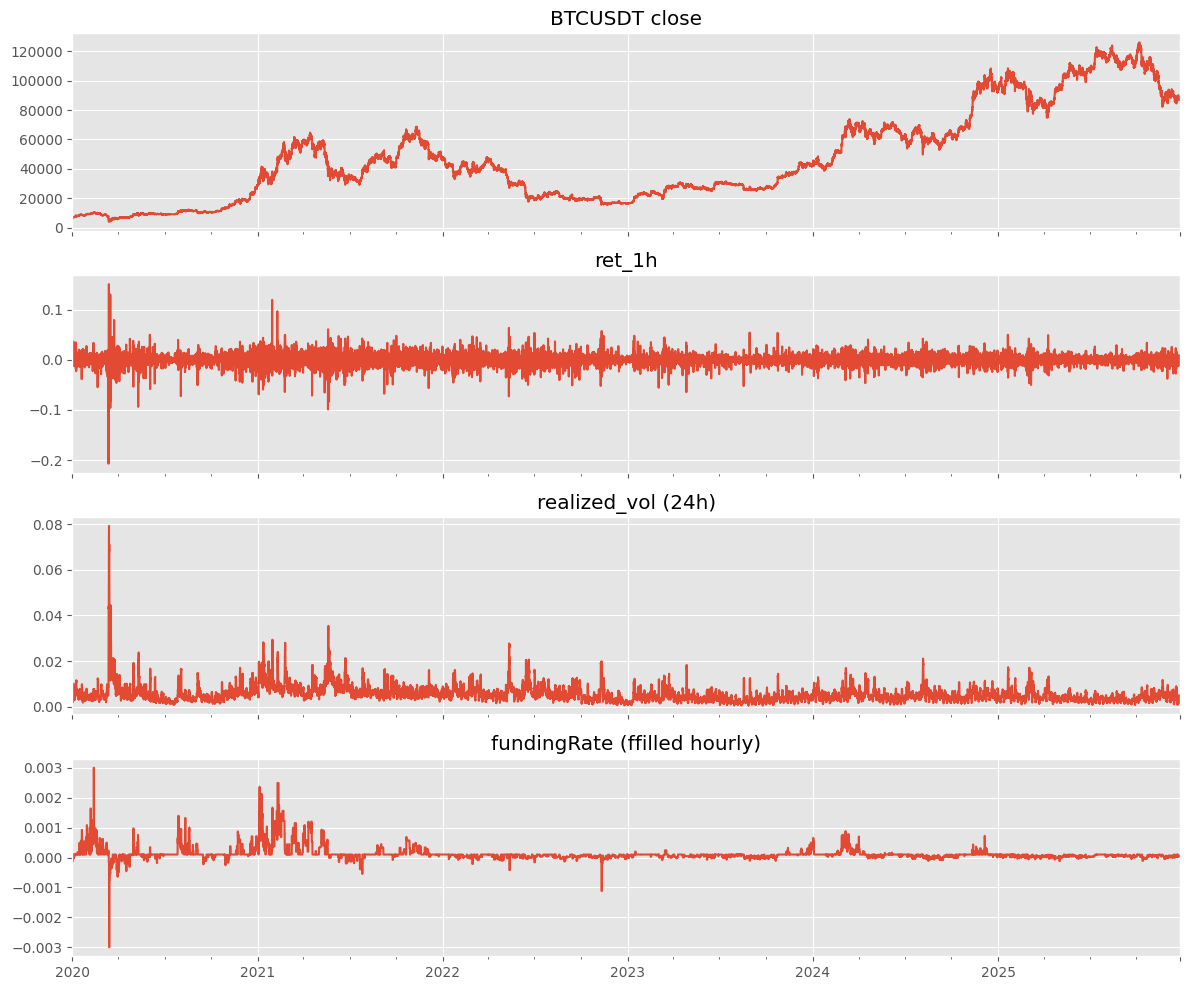

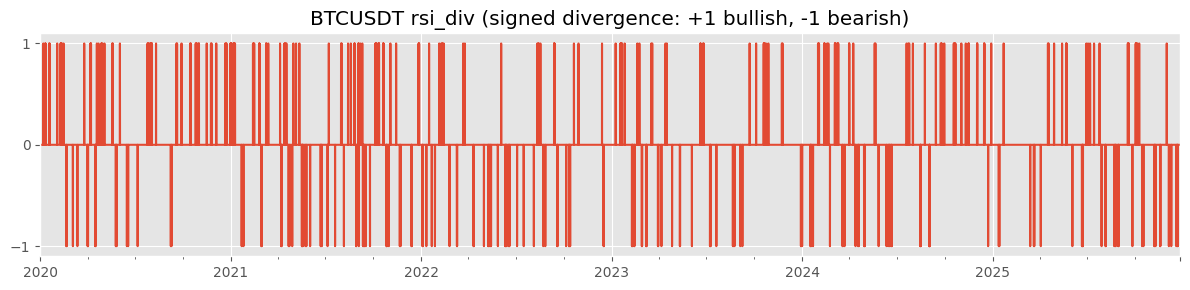

BTCUSDT div counts: {0.0: 51502, 1.0: 535, -1.0: 427}


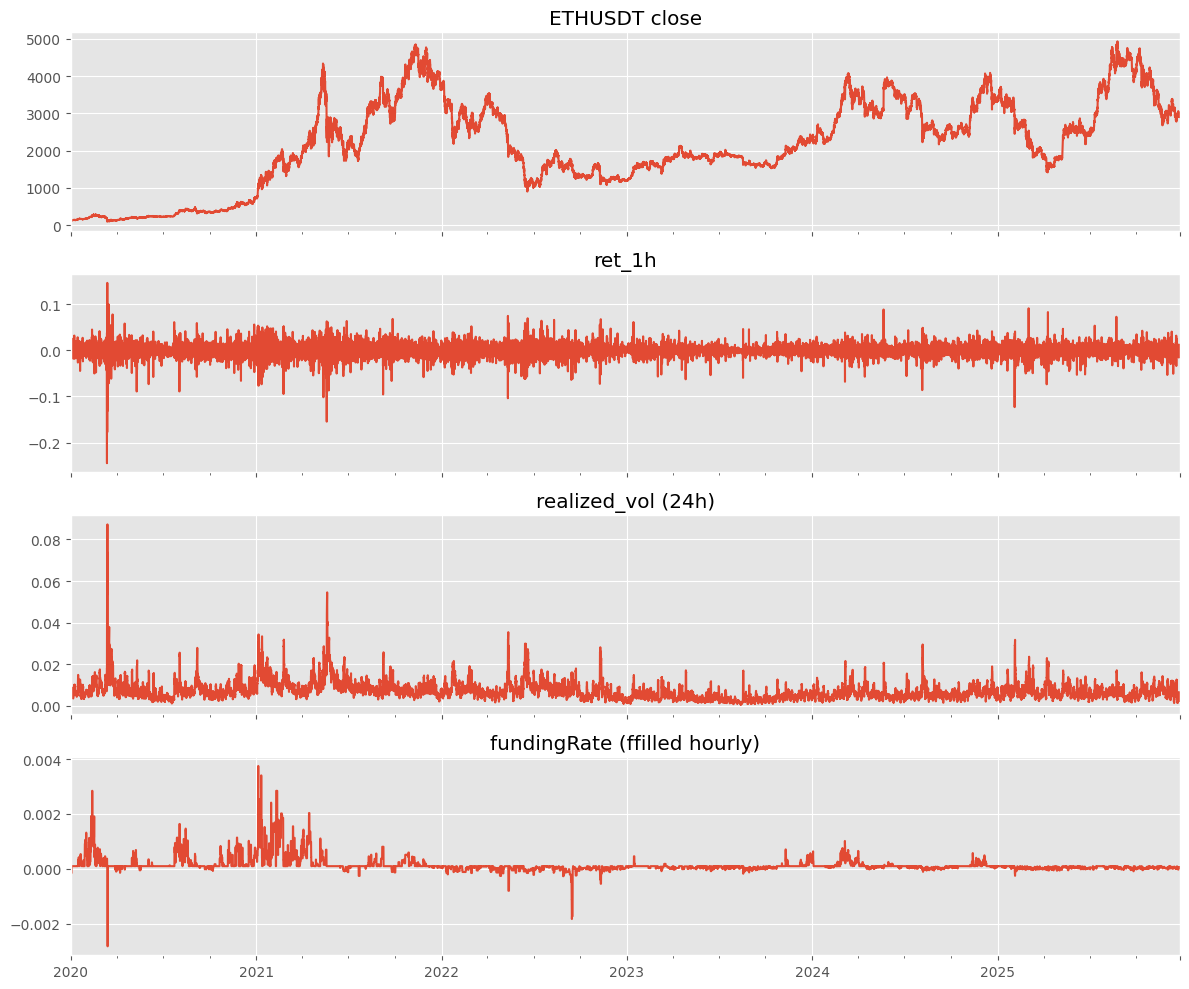

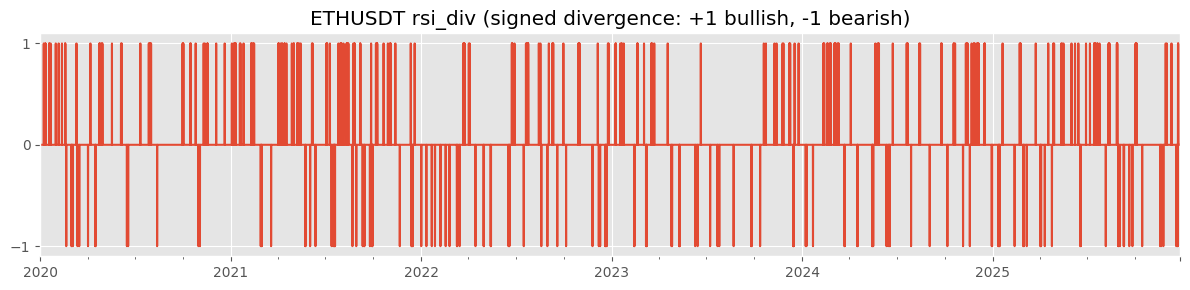

ETHUSDT div counts: {0.0: 51549, 1.0: 599, -1.0: 316}


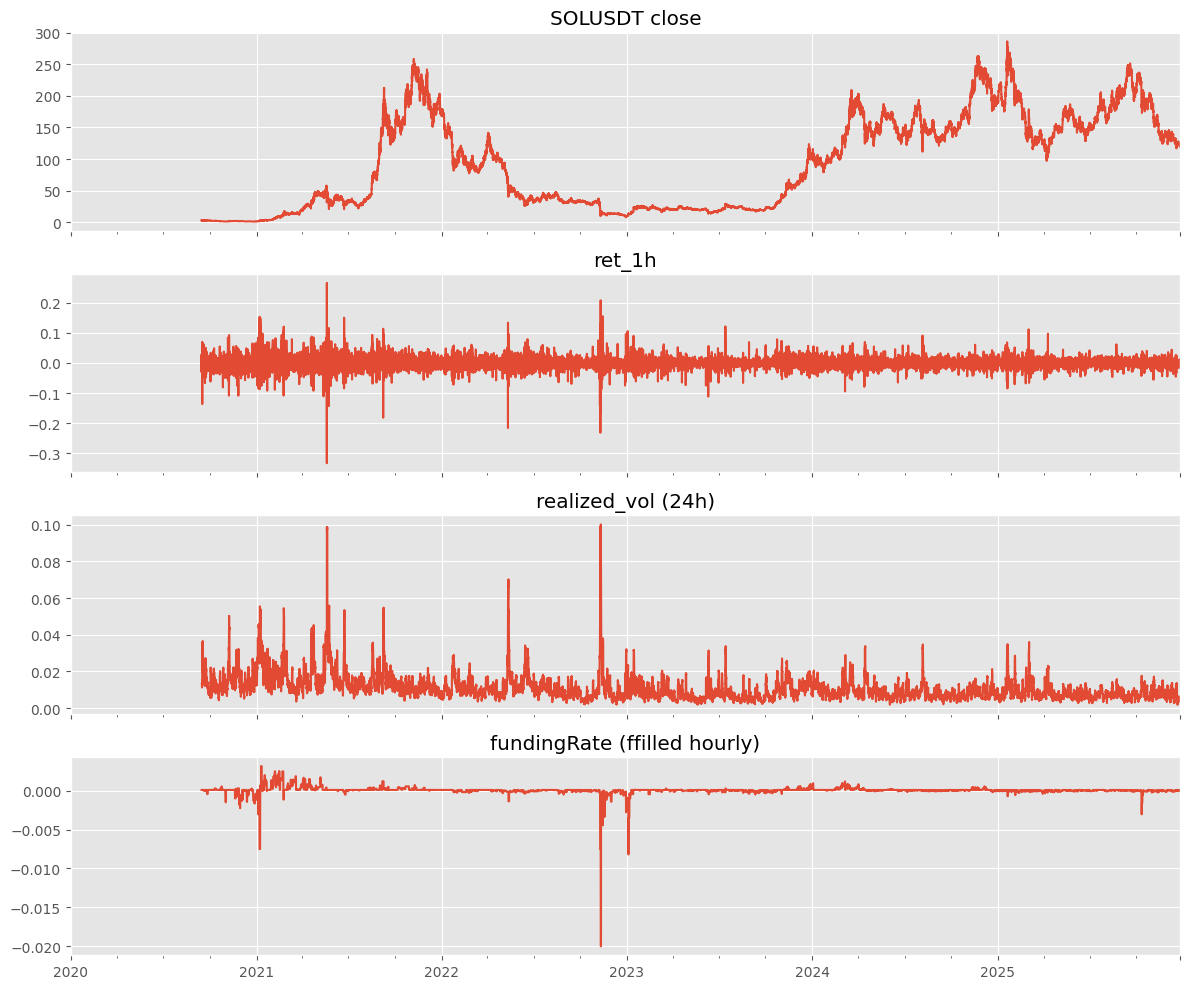

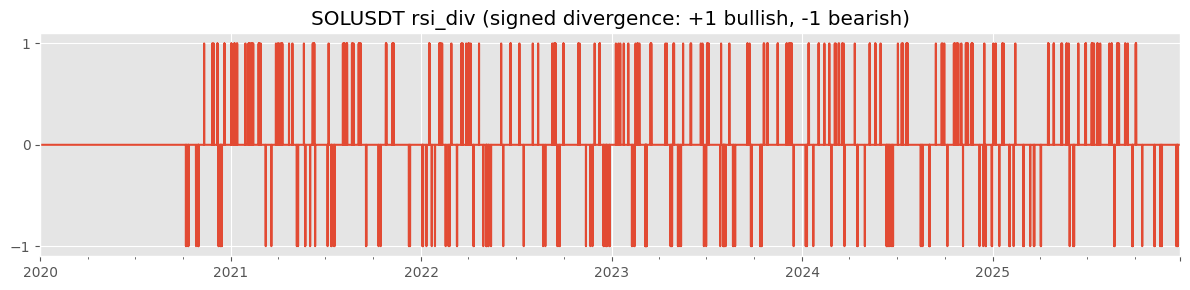

SOLUSDT div counts: {0.0: 51424, 1.0: 647, -1.0: 393}


In [8]:
for sym in PERP_SYMBOLS:
    df = feature_dfs[sym]
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    df["close"].plot(ax=axes[0]); axes[0].set_title(f"{sym} close")
    df["ret_1h"].plot(ax=axes[1]); axes[1].set_title("ret_1h")
    df["realized_vol"].plot(ax=axes[2]); axes[2].set_title("realized_vol (24h)")
    df["fundingRate"].plot(ax=axes[3]); axes[3].set_title("fundingRate (ffilled hourly)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 3))
    df["rsi_div"].plot()
    plt.title(f"{sym} rsi_div (signed divergence: +1 bullish, -1 bearish)")
    plt.yticks([-1, 0, 1])
    plt.tight_layout()
    plt.show()

    print(sym, "div counts:", df["rsi_div"].value_counts(dropna=False).to_dict())


In [9]:
future_ret = df["ret_1h"].shift(-1)  # 1h ahead
print(df.groupby("rsi_div")[future_ret.name].mean())


rsi_div
-1.0   -0.012559
 0.0   -0.000023
 1.0    0.014740
Name: ret_1h, dtype: float64


In [10]:
for h in [1,3,6,12]:
    fut = df["ret_1h"].shift(-h)
    means = df.groupby("rsi_div")[fut.name].mean()
    print(h, means.to_dict())


1 {-1.0: -0.012559424225092332, 0.0: -2.2718870303098843e-05, 1.0: 0.014740353663398396}
3 {-1.0: -0.012559424225092332, 0.0: -2.2718870303098843e-05, 1.0: 0.014740353663398396}
6 {-1.0: -0.012559424225092332, 0.0: -2.2718870303098843e-05, 1.0: 0.014740353663398396}
12 {-1.0: -0.012559424225092332, 0.0: -2.2718870303098843e-05, 1.0: 0.014740353663398396}


In [11]:
sig = df["rsi_div"].copy()

for h in [1, 3, 6, 12]:
    fut = df["ret_1h"].shift(-h)              # h-hours ahead
    tmp = pd.DataFrame({"sig": sig, "fut": fut}).dropna()
    means = tmp.groupby("sig")["fut"].mean()
    counts = tmp["sig"].value_counts().sort_index()
    print(f"\nH={h}h  counts={counts.to_dict()}")
    print(f"means={means.to_dict()}")



H=1h  counts={-1.0: 393, 0.0: 45248, 1.0: 647}
means={-1.0: -0.00028656598161581605, 0.0: 7.901860393486132e-05, 1.0: 0.00017056923680567265}

H=3h  counts={-1.0: 393, 0.0: 45248, 1.0: 647}
means={-1.0: -0.00041752676391501055, 0.0: 8.265675651167549e-05, 1.0: -4.317224325864117e-06}

H=6h  counts={-1.0: 393, 0.0: 45248, 1.0: 647}
means={-1.0: 0.0004421917720708797, 0.0: 6.808488283236466e-05, 1.0: 0.0004925587503248343}

H=12h  counts={-1.0: 393, 0.0: 45248, 1.0: 647}
means={-1.0: 0.0001424636093252012, 0.0: 7.351591751600222e-05, 1.0: 0.0002947994158485112}


In [12]:
for h in [1, 3, 6, 12]:
    fut = df["ret_1h"].shift(-h)
    tmp = pd.DataFrame({
        "bear": df["bearish_div"],
        "bull": df["bullish_div"],
        "fut": fut
    }).dropna()

    print("\nH=", h)
    print("bearish mean fut:", tmp.loc[tmp["bear"]==1, "fut"].mean(), "n=", int((tmp["bear"]==1).sum()))
    print("bullish mean fut:", tmp.loc[tmp["bull"]==1, "fut"].mean(), "n=", int((tmp["bull"]==1).sum()))
    print("neutral mean fut:", tmp.loc[(tmp["bear"]==0)&(tmp["bull"]==0), "fut"].mean())



H= 1
bearish mean fut: 0.00017056923680567265 n= 647
bullish mean fut: -0.00028656598161581605 n= 393
neutral mean fut: 7.901860393486132e-05

H= 3
bearish mean fut: -4.317224325864117e-06 n= 647
bullish mean fut: -0.00041752676391501055 n= 393
neutral mean fut: 8.265675651167548e-05

H= 6
bearish mean fut: 0.0004925587503248343 n= 647
bullish mean fut: 0.0004421917720708797 n= 393
neutral mean fut: 6.808488283236466e-05

H= 12
bearish mean fut: 0.0002947994158485112 n= 647
bullish mean fut: 0.0001424636093252012 n= 393
neutral mean fut: 7.351591751600222e-05


In [13]:
import numpy as np

def boot_mean(x, B=2000, seed=0):
    rng = np.random.default_rng(seed)
    x = np.asarray(x)
    boots = [rng.choice(x, size=len(x), replace=True).mean() for _ in range(B)]
    return np.mean(boots), np.quantile(boots, [0.025, 0.975])

for h in [1,3,6,12]:
    fut = df["ret_1h"].shift(-h)
    tmp = pd.DataFrame({"bear": df["bearish_div"], "bull": df["bullish_div"], "fut": fut}).dropna()

    bear_x = tmp.loc[tmp["bear"]==1, "fut"].to_numpy()
    bull_x = tmp.loc[tmp["bull"]==1, "fut"].to_numpy()

    print("\nH", h)
    print("bear mean, 95% CI:", boot_mean(bear_x))
    print("bull mean, 95% CI:", boot_mean(bull_x))



H 1
bear mean, 95% CI: (0.00017282698680855856, array([-0.00103293,  0.00141345]))
bull mean, 95% CI: (-0.00025718052320541153, array([-0.00154138,  0.00101158]))

H 3
bear mean, 95% CI: (-2.0489494528317455e-06, array([-0.00109081,  0.00105041]))
bull mean, 95% CI: (-0.00040409878616636273, array([-0.00195077,  0.00111837]))

H 6
bear mean, 95% CI: (0.00048555464766880744, array([-0.00052992,  0.0014417 ]))
bull mean, 95% CI: (0.000444012833452888, array([-0.00093991,  0.00187124]))

H 12
bear mean, 95% CI: (0.0003028773545224921, array([-0.00078781,  0.00142703]))
bull mean, 95% CI: (0.00015570617559190463, array([-0.00106433,  0.0013607 ]))
